# Requirements

Importing the necessary libraries.

In [18]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import pickle

import os

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LinearRegression

from pyramid.arima import auto_arima

from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


Some useful functions to support the constructions in this project.

In [2]:
def expand_date_in_dataframe(df):
    """
    It breaks the date attibute (assuming it's a datetime) of a dataframe in more fileds
    for year, month, day, week, day of week, day of year and timestamp.
    """
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)


def str_to_datetime(date):
    """
    Converts a string into a datetime.

    :param str date: The string representation in the format 'yyyy-mm-dd' of the date to convert.
    :return: The resulting datetime.
    :rtype: datetime.datetime
    """
    return datetime.datetime.strptime(date, '%Y-%m-%d')


def datetime_array_to_dataframe(days):
    """
    Gets a dataframe from an array of dates.

    :param list[datetime.datetime] date: The array of dates.
    :return: The dataframe.
    :rtype: pandas.DataFrame
    """
    return pd.DataFrame({'date': days})

# Dataset

In [3]:
class Dataset:
    """
    This class is used to manage the dataset that contains the hsitoric stock prices
    for the companies contemplated in the Dow Jones Industrial Average.
    """

    """ Ticker symbols of the companies contemplated in the  Dow Jones Industrial Average. """
    DJIA_TICKERS = [
        'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
        'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
        'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

    """ Value used to get the historical data from 5 years ago. """
    HIST_5Y = '5y'

    """ Value used to get the historical data from 1 year ago. """
    HIST_1Y = '1y'

    """ Value used to get the historical data from 1 month ago. """
    HIST_1M = '1m'

    """
    This is the template to create the URL to extract historical stock prices
    from the IEX API.
    """
    __IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/{}'


    def __init__(self, dataframe=None):
        """
        The constructor of Dataset.

        :param pandas.DataFrame df: The dataframe containing stock price historical records,
                                    which will be actual data.
        """
        self.dataframe = dataframe


    @staticmethod
    def __preprocess_dataframe(df):
        """
        Pre-processes a dataframe containing stock price historical records (from IEX)
        by removing the columns that are not useful to make future predictions
        and expanding the date in more columns.

        :param pandas.DataFrame df: The dataframe containing stock price historical records.
        :return: The pre-processed dataframe.
        :rtype: pandas.DataFrame
        """
        formated_df = df.drop(['label',
                               'change', 'changeOverTime', 'changePercent',
                               'high', 'low', 'open',
                               'unadjustedVolume', 'volume', 'vwap'],
                              axis=1)

        expand_date_in_dataframe(formated_df)
        return formated_df


    @staticmethod
    def __get_dataframe_for_ticker(ticker_symbol, hist_period):
        """
        Retrieves the historic prices for a particuler stock from the data source,
        i.e. the IEX API.

        :param str ticker_symbol: The ticker symbol or symbols to filter the data.
        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        # Getting the historic records from IEX
        r = requests.get(url=Dataset.__IEX_API_URL_TEMPLATE.format(ticker_symbol.lower(), hist_period))
        df = json_normalize(r.json())

        # Converting the date to a datetime
        df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

        # Adding the ticker symbol as a new column
        df.insert(loc=0, column='symbol', value=ticker_symbol)

        return Dataset.__preprocess_dataframe(df)


    @staticmethod
    def __get_djia_dataframe(hist_period):
        """
        Gets a dataframe containing historic prices for stocks in the Dow Jones Industrial Average.

        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        df = None

        # Retrieves the historic records for each one of the ticker symbols in the
        # Dow Jones Industrial Average
        for ticker_symbol in Dataset.DJIA_TICKERS:
            if df is None:
                df = Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period)
            else:
                df = df.append(Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period))

        return df


    @staticmethod
    def __update_djia_dataframe(df):
        """
        Updates a dataframe containing historic prices for stocks in the Dow Jones Industrial Average,
        by retrieving the most recent records from the information source.

        :param pandas.DataFrame hist_period: The dataframe containing stock price historical records.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """

        # Getting the amount of days that need to be updated
        last_recorded_day = max(df.date)
        today = datetime.datetime.now()
        days_to_update = (today - last_recorded_day).days

        # Deciding the historic period to request to the source according to the days that
        # need to be updated
        hist_period = Dataset.HIST_5Y
        if days_to_update < 1:
            return df
        elif days_to_update < 28:
            hist_period = Dataset.HIST_1M
        elif days_to_update < 365:
            hist_period = Dataset.HIST_1Y

        # Getting the data frame containing the missing records
        last_df = Dataset.__get_djia_dataframe(hist_period)

        # Appending the missing records, dropping the duplicates and returning
        return df.append(last_df).drop_duplicates(['symbol', 'date'], keep='last')


    @staticmethod
    def loadDatasetFromFile(file_name):
        """
        Loads the dataset from a file where data was previously stored.

        :param str file_name: The name of the file to load the data from. 
        """
        with open(file_name, 'rb') as fp:
            return Dataset(pickle.load(fp))


    def saveDataToFile(self, file_name=None):
        """
        Saves the current dataset to a file.

        :param file_name: The name of the file to save the data,
                          if None the data is saved to a file n the 'data' directory
                          using a name of the form 'djia_yyyymmdd-yyyymmdd.pkl'
                          with the minimum and maximum recorded dates. 
        :type file_name: str or None
        """
        if file_name is None:
            file_name = os.path.join(
                'data',
                'djia_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(min(self.dataframe.date), max(self.dataframe.date)))

        with open(file_name, 'wb') as fp:
            pickle.dump(self.dataframe, fp)


    def createData(self, hist_period=HIST_5Y):
        """
        Initializes the dataset with brand new data,
        by default it retrieves historical records from the last 5 years.

        :param str hist_period: The period to retrieve historical records, 5 years ('5y') by default.
        """
        self.dataframe = Dataset.__get_djia_dataframe(hist_period)


    def updateData(self):
        """
        Updates the dataset by getting the most recent history records from the source.
        Note: This method is intended to be run periodicaly in order to keep the dataset up to date.
        """
        self.dataframe = Dataset.__update_djia_dataframe(self.dataframe)


    def getDataframe(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a dataframe containing a subset of the records of the current dataset,
        which is obtained by filtering by a ticker symbol or list (array) of ticker symbols
        and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The dataframe with the subset resulted of filtering the dataset.
        :rtype: pandas.DataFrame
        """
        df = self.dataframe

        if ticker_symbol is not None:
            if isinstance(ticker_symbol, str): # If ticker_symbol symbol is a string
                df = df.query("symbol == '{}'".format(ticker_symbol))
            elif isinstance(ticker_symbol, list): # If ticker_symbol symbol is an array
                # Creates a query expression as a sequence of ORs
                ticker_symbol_query = None
                for t in ticker_symbol:
                    ticker_symbol_exp = "symbol == '{}'".format(t)
                    if ticker_symbol_query is None:
                        ticker_symbol_query = ticker_symbol_exp
                    else:
                        ticker_symbol_query += "or " + ticker_symbol_exp
                df = df.query(ticker_symbol_query)

        if from_date is not None:
            df = df.query("date >= '{}'".format(from_date))

        if to_date is not None:
            df = df.query("date <= '{}'".format(to_date))

        return df


    
    def getSubset(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a subset of the current dataset filtered 
        by a ticker symbol or list (array) of ticker symbols and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The subset resulted of filtering the dataset.
        :rtype: Dataset
        """
        df = self.getDataframe(ticker_symbol=ticker_symbol, from_date=from_date, to_date=to_date)
        return Dataset(df)

# Trading days

In [4]:
class TradingDaysHelper:
    """
    This is a helper to retrieve the days that the market is open.
    The market holidyas are loaded from a file, by default 'market_holidays.txt'.
    """

    def __init__(self, market_holidays_file='market_holidays.txt'):
        """
        The constructor.

        :param str market_holidays_file: The file containing the market holidays,
                                         by default 'market_holidays.txt'.
        """
        self.market_holidays = []

        with open(market_holidays_file) as f:
            lines = f.readlines()

        for line in lines:
            self.market_holidays.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))


    def __is_trading_day(self, day):
        """
        Verifies if in a particular day the market is open.

        :param datetime.datetime day: The day to verify if the marke is open.
        :return: True if the marke is open of False otherwise.
        :rtype: bool
        """
        day_of_week = day.weekday()
        if day_of_week == 5 or day_of_week == 6 or day in self.market_holidays:
            return False
        else:
            return True


    def get_trading_days_in_range(self, start_date, end_date):
        """
        Getting the trading days existing in a date range.

        :param datetime.datetime from_date: The starting date of the range.
        :param datetime.datetime to_date: The ending date of the range.
        :return: A list of the trading days in the specified date range.
        :rtype: list[datetime.datetime]
        """
        trading_days = []

        current_day = start_date
        while (current_day <= end_date):
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)
            current_day += datetime.timedelta(days=1)

        return trading_days

# Models

In [5]:
class StockForecasterModel:
    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        self.ticker_symbol = ticker_symbol
        self.dataset = dataset
        self.trading_days_helper = trading_days_helper

    def train(self, start_date=None, end_date=None):
        raise NotImplementedError('Please Implement this method')

    def predict(self, from_date, to_date=None):
        raise NotImplementedError('Please Implement this method')

In [6]:
class LinearStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)

    def train(self, start_date=None, end_date=None):
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)

        x = training_set.drop(['symbol', 'date', 'close'], axis=1)
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)

    def predict(self, from_date, to_date=None):
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')

        days_to_predict = self.trading_days_helper.get_trading_days_in_range(from_date, to_date)

        x = datetime_array_to_dataframe(days_to_predict)
        expand_date_in_dataframe(x)
        x = x.drop(['date'], axis=1)

        y = self.model.predict(x)
        
        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})

In [7]:
class ArimaStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)
        self.training_end = None

    def train(self, start_date=None, end_date=None):
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)
        self.training_end = max(training_set.date)

        training_set = training_set.close

        self.model = auto_arima(training_set,
                                start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0,
                                seasonal=True, d=1, D=1, trace=True,
                                error_action='ignore', suppress_warnings=True)
        self.model.fit(training_set)

    def predict(self, from_date, to_date=None):
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        y = self.model.predict(n_periods=len(days_to_predict))
        
        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})\
                 .query("date >= '{}' and date <= '{}'".format(from_date, to_date))


In [8]:
class ProphetStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)
        self.training_end = None

    def train(self, start_date=None, end_date=None):
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)
        self.training_end = max(training_set.date)

        self.training_set = pd.DataFrame(training_set, columns=['date', 'close'])
        self.training_set.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

        self.model = Prophet(daily_seasonality=True)
        self.model.fit(self.training_set)

    def predict(self, from_date, to_date=None):
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        y = self.model.make_future_dataframe(periods=len(days_to_predict))
        y = self.model.predict(y)['yhat'][self.training_set.shape[0]:]
        
        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})\
                 .query("date >= '{}' and date <= '{}'".format(from_date, to_date))

In [57]:
class LongShortTermMemoryStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)
        self.training_end = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.timesteeps = 60

    def train(self, start_date=None, end_date=None):
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        self.training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                      from_date=start_date, to_date=end_date)
        self.training_end = max(self.training_set.date)
        self.training_set = pd.DataFrame(self.training_set, columns=['close'])
        scaled_training_set = self.scaler.fit_transform(self.training_set)

        x_train, y_train = [], []
        for i in range(self.timesteeps, len(scaled_training_set)):
            x_train.append(scaled_training_set[i - self.timesteeps : i, 0])
            y_train.append(scaled_training_set[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # Creating and fitting the LSTM network
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        self.model.add(LSTM(units=50))
        self.model.add(Dense(1))

        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    def predict(self, from_date, to_date=None):
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        inputs = self.training_set.close[len(self.training_set) - self.timesteeps:].values
        inputs = inputs.reshape(-1,1)
        inputs = self.scaler.transform(inputs).reshape(-1)

        y = []

        for i in range(0, len(days_to_predict)):
            x = np.array(inputs[i : i + self.timesteeps])
            x = np.reshape(x, (1, self.timesteeps, 1))

            pred = self.model.predict(x)
            y.append(self.scaler.inverse_transform(pred).reshape(-1)[0])
            #inputs = np.append(inputs, pred)

            #existing_rec = self.dataset.dataframe\
            #               .loc[(df['date'] == days_to_predict[i]) & (df['symbol'] == self.ticker_symbol)]
            existing_rec = self.dataset.dataframe.query(
                "date == '{}' and symbol == '{}'".format(days_to_predict[i], self.ticker_symbol))
            if len(existing_rec) > 0:
                inputs = np.append(
                    inputs, self.scaler.transform(existing_rec.close.values.reshape(-1,1)).reshape(-1)[0])
            else:
                inputs = np.append(inputs, pred)

        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})\
                 .query("date >= '{}' and date <= '{}'".format(from_date, to_date))

# Analysis

In [14]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [69]:
def measure_performance(results, subplot, method_name, model_constructor, total_dataset,
                        ticker_symbol,
                        training_start, training_end,
                        validation_days=[1, 7, 15, 30, 60, 90, 180],
                        simulate_up_to_date_dataset=False):

    validation_start = training_end + datetime.timedelta(days=1)
    max_validation_end = validation_start + datetime.timedelta(days=max(validation_days))
    total_validation_ds = total_dataset.getSubset(ticker_symbol=ticker_symbol,
                                                  from_date=validation_start,
                                                  to_date=max_validation_end)

    training_df = total_dataset.getDataframe(ticker_symbol=ticker_symbol,
                                             from_date=training_start,
                                             to_date=training_end)

    if simulate_up_to_date_dataset:
        dataset = total_dataset.getSubset(ticker_symbol=ticker_symbol,
                                          from_date=training_start,
                                          to_date=max_validation_end)
    else:
        dataset = total_dataset.getSubset(ticker_symbol=ticker_symbol,
                                          from_date=training_start,
                                          to_date=training_end)

    model = model_constructor(ticker_symbol, dataset, trading_days_helper)
    model.train(start_date=training_start, end_date=training_end)

    for v in validation_days:
        validation_end = validation_start + datetime.timedelta(days=v)
        preds = model.predict(validation_start, validation_end)
        validation_df = total_validation_ds.getDataframe(ticker_symbol=ticker_symbol,
                                                         from_date=validation_start,
                                                         to_date=validation_end)

        results.append({'method' : method_name,
                        'symbol': ticker_symbol,
                        'forecasting_days': v,
                        'RMSE': rmse(preds.predicted_price.values, validation_df.close.values)})

    subplot.plot(training_df.date, training_df.close, label='Training')
    subplot.plot(total_validation_ds.dataframe.date, total_validation_ds.dataframe.close, label='Validation')
    subplot.plot(preds.date, preds.predicted_price, label='Prediction')
    subplot.set_title(method_name)
    subplot.legend()

    return results

# POCs

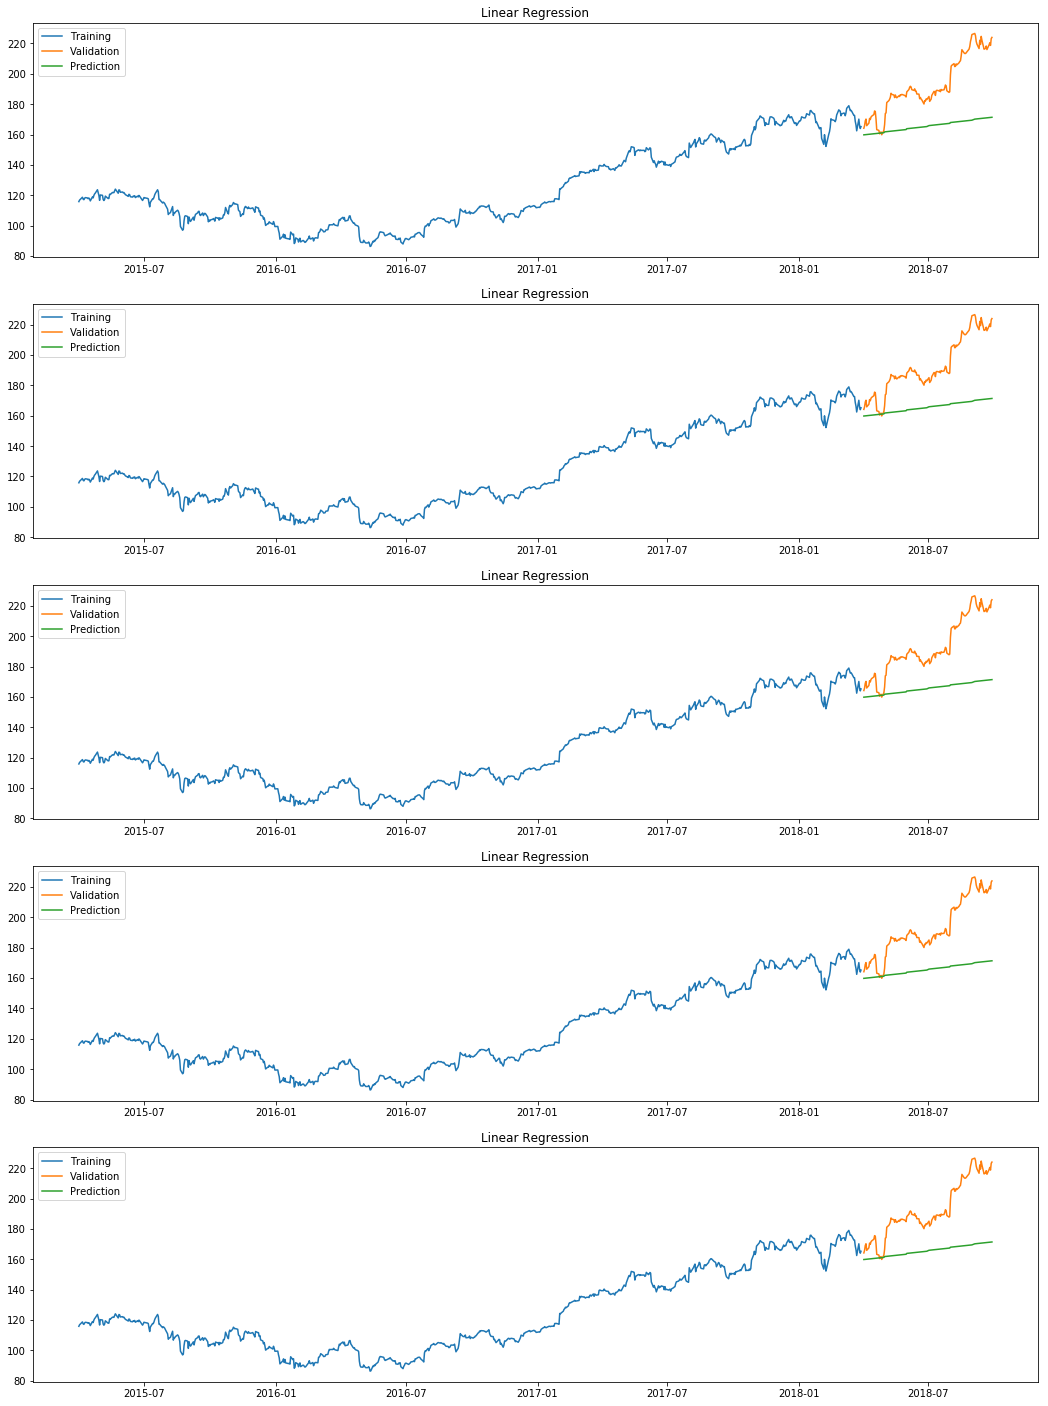

               method symbol  forecasting_days       RMSE
0   Linear Regression   AAPL                 1   4.358373
1   Linear Regression   AAPL                 7   7.439488
2   Linear Regression   AAPL                15   9.313558
3   Linear Regression   AAPL                30   8.307899
4   Linear Regression   AAPL                60  16.288076
5   Linear Regression   AAPL                90  18.457619
6   Linear Regression   AAPL               180  30.924584
7   Linear Regression   AAPL                 1   4.358373
8   Linear Regression   AAPL                 7   7.439488
9   Linear Regression   AAPL                15   9.313558
10  Linear Regression   AAPL                30   8.307899
11  Linear Regression   AAPL                60  16.288076
12  Linear Regression   AAPL                90  18.457619
13  Linear Regression   AAPL               180  30.924584
14  Linear Regression   AAPL                 1   4.358373
15  Linear Regression   AAPL                 7   7.439488
16  Linear Reg

In [70]:
trading_days_helper = TradingDaysHelper()
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))

ticker_symbol = 'AAPL'
training_start = str_to_datetime('2015-04-01')
training_end = str_to_datetime('2018-03-31')

results = []

fig = plt.figure(figsize=(18, 25))

ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

measure_performance(results, ax1, 'Linear Regression', LinearStockForecaster, ds, ticker_symbol, training_start, training_end)
measure_performance(results, ax2, 'Linear Regression', LinearStockForecaster, ds, ticker_symbol, training_start, training_end)
measure_performance(results, ax3, 'Linear Regression', LinearStockForecaster, ds, ticker_symbol, training_start, training_end)
measure_performance(results, ax4, 'Linear Regression', LinearStockForecaster, ds, ticker_symbol, training_start, training_end)
measure_performance(results, ax5, 'Linear Regression', LinearStockForecaster, ds, ticker_symbol, training_start, training_end)
#measure_performance(results, ax2, 'ARIMA', ArimaStockForecaster, ds, ticker_symbol, training_start, training_end)
#measure_performance(results, ax3, 'Prophet', ProphetStockForecaster, ds, ticker_symbol, training_start, training_end)
#measure_performance(results, ax4, 'LSTM', LongShortTermMemoryStockForecaster, ds, ticker_symbol, training_start, training_end)
#measure_performance(results, ax4, 'LSTM', LongShortTermMemoryStockForecaster, ds, ticker_symbol, training_start, training_end, simulate_up_to_date_dataset=True)
plt.show()

#results_df = pd.DataFrame(columns = ['method', 'symbol', 'forecasting_days', 'RMSE'], data = results)
#print(results_df)

In [ ]:
trading_days_helper = TradingDaysHelper()
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))

training_start = str_to_datetime('2015-04-01')
training_end = str_to_datetime('2018-03-31')

results = []

fig = plt.figure(figsize=(18, 12))

ax3 = fig.add_subplot(111)

measure_performance(results, ax3, 'Prophet', ProphetStockForecaster, ds, 'AAPL', training_start, training_end)
plt.show()

results_df = pd.DataFrame(columns = ['method', 'symbol', 'forecasting_days', 'RMSE'], data = results)
print(results_df)

In [53]:
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
df = ds.dataframe
#print(df)
#record = df.loc[(df['date'] == str_to_datetime('2019-03-11')) & (df['symbol'] == 'AAPL')]
record = df.query("date == '{}' and symbol == '{}'".format(str_to_datetime('2019-03-11'), 'AAPL'))

if len(record) > 0:
    print(record.close.values[0])
else:
    print(None)

178.9


In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
df = ds.getDataframe(ticker_symbol='AAPL', from_date=str_to_datetime('2015-04-01'), to_date=str_to_datetime('2018-03-31'))
plt.plot(df.date, df.close, label='Dates')

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
#ds.createData(hist_period=Dataset.HIST_1Y)
#ds.createData()

df = ds.getDataframe()
print('{} --> {}'.format(min(df.date), max(df.date)))

ds.updateData()
df = ds.getDataframe()
print('{} --> {}'.format(min(df.date), max(df.date)))

ds.saveDataToFile()

In [ ]:
perform_test(djia_ds, 'AAPL', LinearStockForecaster,
             str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))

In [ ]:
h = TradingDaysHelper()
days = h.get_trading_days_in_range(TradingDaysHelper.str_to_datetime('2019-04-01'), TradingDaysHelper.str_to_datetime('2019-04-30'))

print(days)

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
trading_days_helper = TradingDaysHelper()

m = LinearStockForecaster('AAPL', ds, trading_days_helper)
m.train(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
preds = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

training_set = ds.getDataframe('AAPL', str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
validation_set = ds.getDataframe('AAPL', str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

plt.plot(training_set.date, training_set.close, label='Training')
plt.plot(validation_set.date, validation_set.close, label='Validation')
plt.plot(preds.date, preds.predicted_price, label='Prediction')

print(preds)

In [ ]:
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
trading_days_helper = TradingDaysHelper()
#print(ds.dataframe)

#ts = ds.getSubset(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
#tdf = ts.getDataframe()
#print('{} --> {}'.format(min(tdf.date), max(tdf.date)))

tds = ds.getSubset(ticker_symbol=['AAPL', 'IBM', 'MSFT'], from_date=str_to_datetime('2019-03-01'), to_date=str_to_datetime('2019-03-10'))
print(tds.dataframe)

In [ ]:
trading_days_helper = TradingDaysHelper()

ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
training_ds = ds.getSubset(ticker_symbol='AAPL',
                           from_date=str_to_datetime('2015-04-01'),
                           to_date=str_to_datetime('2018-03-31'))
validation_ds = ds.getSubset(ticker_symbol='AAPL',
                             from_date=str_to_datetime('2018-04-01'),
                             to_date=str_to_datetime('2018-06-30'))

m = LinearStockForecaster('AAPL', training_ds, trading_days_helper)
m.train()
preds = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

plt.plot(training_ds.dataframe.date, training_ds.dataframe.close, label='Training')
plt.plot(validation_ds.dataframe.date, validation_ds.dataframe.close, label='Validation')
plt.plot(preds.date, preds.predicted_price, label='Prediction')

print(preds)